# Doublet identification in Multiome-RNA (adult) dataset using _scrublet_ 

In [1]:
# import numpy as np
# import pandas as pd
# import scanpy as sc
# import scrublet as scr
import matplotlib.pyplot as plt
# import scipy.sparse as sp

# import tables
# from typing import Dict
# from fastprogress.fastprogress import  progress_bar

from scanpy import logging as logg
from scanpy.neighbors import neighbors
from anndata import AnnData
from scipy.sparse import csc_matrix

from utils import *

In [2]:
sc.settings.verbosity = 3
sc.logging.print_version_and_date()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

Running Scanpy 1.8.1, on 2021-09-23 10:09.


## Create AnnData objects

In [3]:
metadata = pd.read_csv('/nfs/team205/heart/metadata/metadata_adult_multiomeRNA.csv', sep = ',', index_col = 0)

In [4]:
metadata

,Foetal_or_Adult,Provider,Modality,Chemistry,Mapping_ver,Reference_genome
sample_id,,,,,,
HCAHeart9508627,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9508628,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9508629,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9845431,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9845432,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9845433,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9845434,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9845435,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A
HCAHeart9845436,Adult,Sanger Heart Mona-Carlos,Multiome-RNA,Single Cell Multiome ATAC + Gene Expression v1,cellranger-arc-1.0.1,GRCh38-2020-A


In [5]:
path = '/nfs/team205/heart/soupremoved/cellbender020/'

adatas = [anndata_from_h5(path + sample_id + '/' + sample_id + '_cellbender_out_filtered.h5', analyzed_barcodes_only=False) for sample_id in metadata.index]

In [6]:
n_nuclei=[adatas[i].n_obs for i in range(len(adatas))]
np.quantile(n_nuclei, q=[0.0, 0.25, 0.5, 0.75, 1.0])

array([ 3686.,  5033.,  8640.,  9522., 12696.])

Multiplet rate from [protocol](https://assets.ctfassets.net/an68im79xiti/7x5E4P6xefQruTbFg0yr3a/1381fdcd2d2e7d667ef5b415119dab15/CG000338_ChromiumNextGEM_Multiome_ATAC_GEX_User_Guide_RevE.pdf)

In [7]:
multiplet_rates = pd.read_csv('/nfs/team205/heart/metadata/10x_multiplet_Multiome.csv', sep = ',')

In [8]:
multiplet_rates

,N_Nuclei_Loaded,N_Nuclei_Recovered,Multiplet_Rate
0,775,500,0.004
1,1550,1000,0.008
2,3075,2000,0.016
3,4625,3000,0.023
4,6150,4000,0.031
5,7700,5000,0.039
6,9250,6000,0.046
7,10750,7000,0.054
8,12300,8000,0.062
9,13850,9000,0.069


In [9]:
metadata['n_nuclei']=n_nuclei
metadata['multiplet_rate'] = [multiplet_rates['Multiplet_Rate'][metadata.loc[sample_id,'n_nuclei'] > multiplet_rates['N_Nuclei_Recovered']].max() for sample_id in metadata.index]
expected_doublet_rate = np.multiply(metadata['n_nuclei'], metadata['multiplet_rate']).sum() / metadata['n_nuclei'].sum()
expected_doublet_rate

0.06217856194535672

In [10]:
for i in range(len(adatas)):
    adatas[i].var_names_make_unique()
    adatas[i].obs['sample_id'] = metadata.index[i]
    adatas[i].obs.index = metadata.index[i] + '_' + adatas[i].obs.index 
    for col in metadata.columns:
        adatas[i].obs[col] = metadata[col][i]

adata = adatas[0].concatenate(adatas[1:], batch_categories = metadata.index)
adata.shape

(71555, 36601)

In [11]:
adata.obs['n_counts'] = adata.X.sum(axis = 1)
adata.obs['n_counts'].describe()

count     71555.000000
mean       9878.979492
std       16522.539062
min           0.000000
25%        1811.000000
50%        4827.000000
75%       12263.000000
max      463580.000000
Name: n_counts, dtype: float64

## Remove cells with less than 200 genes, remove genes detected in less than 3 cells

In [12]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 802 cells that have less than 200 genes expressed


/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


filtered out 2993 genes that are detected in less than 3 cells


In [13]:
adata.shape

(70753, 33608)

## Compute QC stats

In [14]:
mito_cells = adata.var_names.str.startswith('MT-')
ribo_cells = adata.var_names.str.startswith('RPS','RPL')
adata.obs['percent_mito'] = np.sum(adata[:, mito_cells].X, axis = 1) / np.sum(adata.X, axis = 1)
adata.obs['percent_ribo'] = np.sum(adata[:, ribo_cells].X, axis = 1) / np.sum(adata.X, axis = 1)

# sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo'], jitter = 0.2, multi_panel = True)
# for qc_metric in ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo']:
#     sc.pl.violin(adata, qc_metric, jitter = 0.2)

... storing 'sample_id' as categorical
... storing 'Foetal_or_Adult' as categorical
... storing 'Provider' as categorical
... storing 'Modality' as categorical
... storing 'Chemistry' as categorical
... storing 'Mapping_ver' as categorical
... storing 'Reference_genome' as categorical
... storing 'feature_type' as categorical


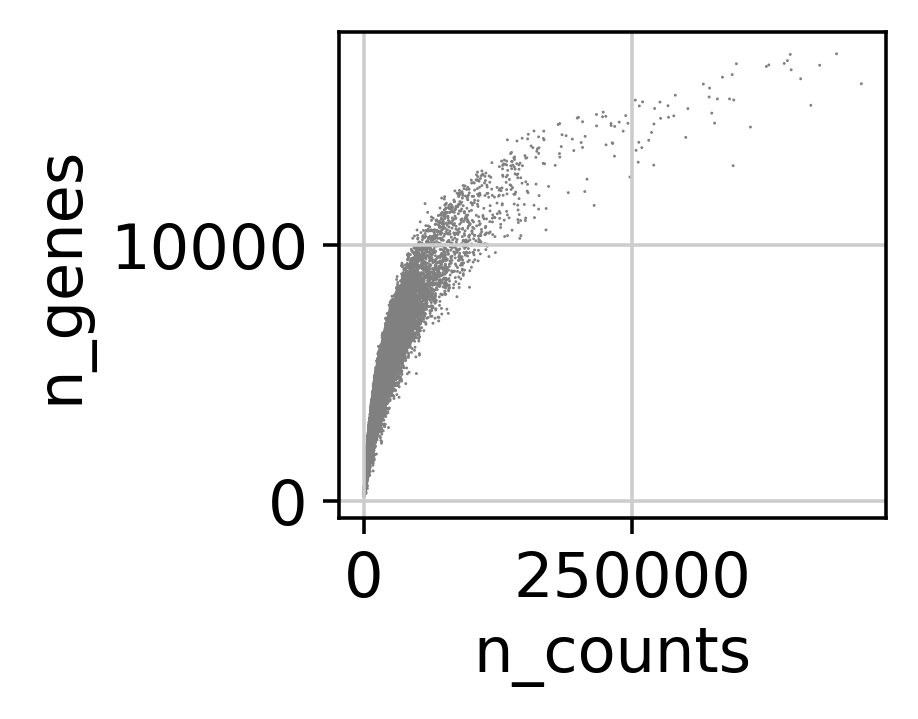

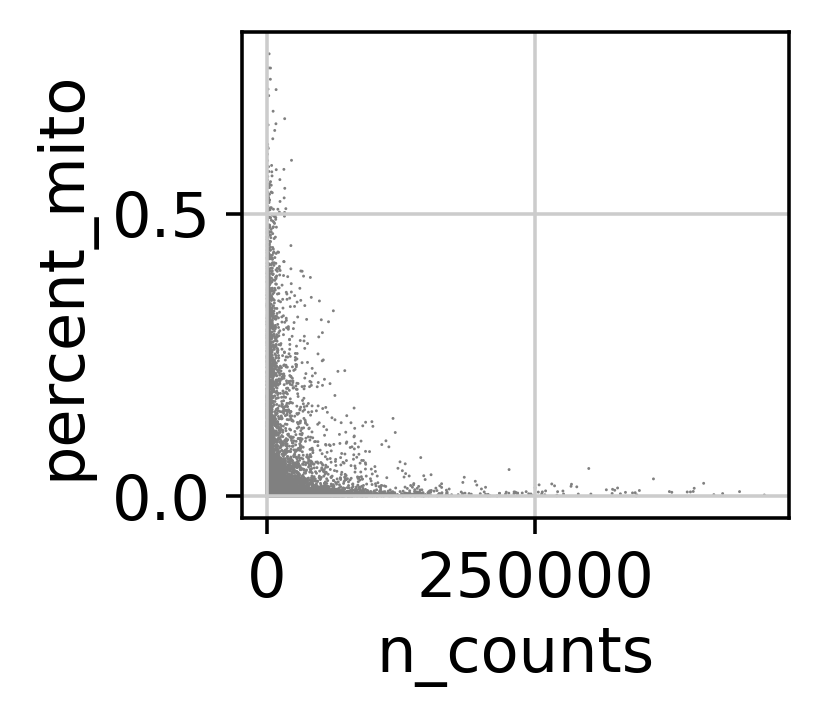

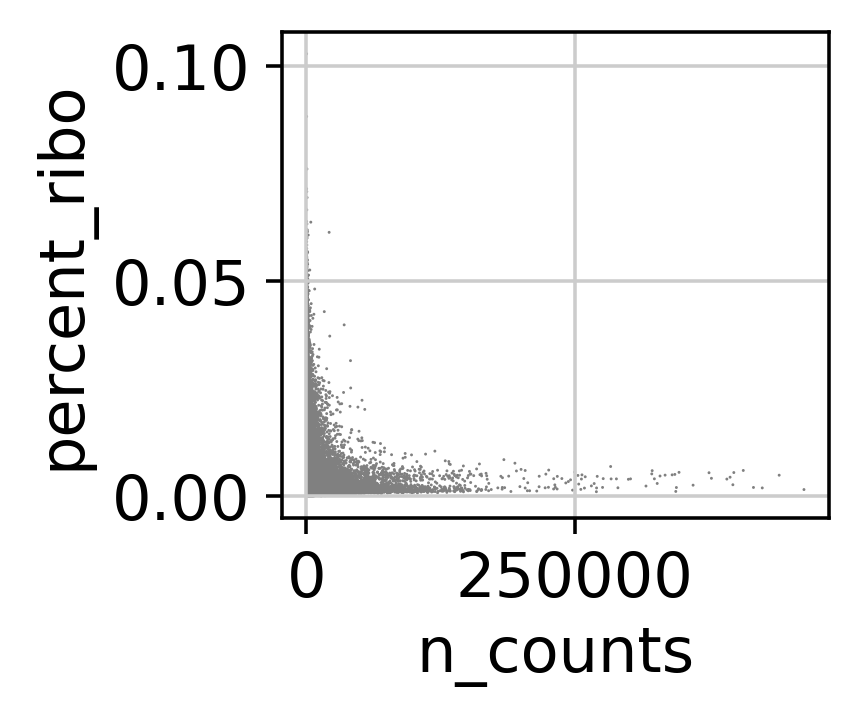

In [15]:
plt.rcParams['figure.figsize'] = [3, 2]

sc.pl.scatter(adata, x='n_counts', y='n_genes')
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='percent_ribo')

## Remove cells exceeding the ribo/mito threshold

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


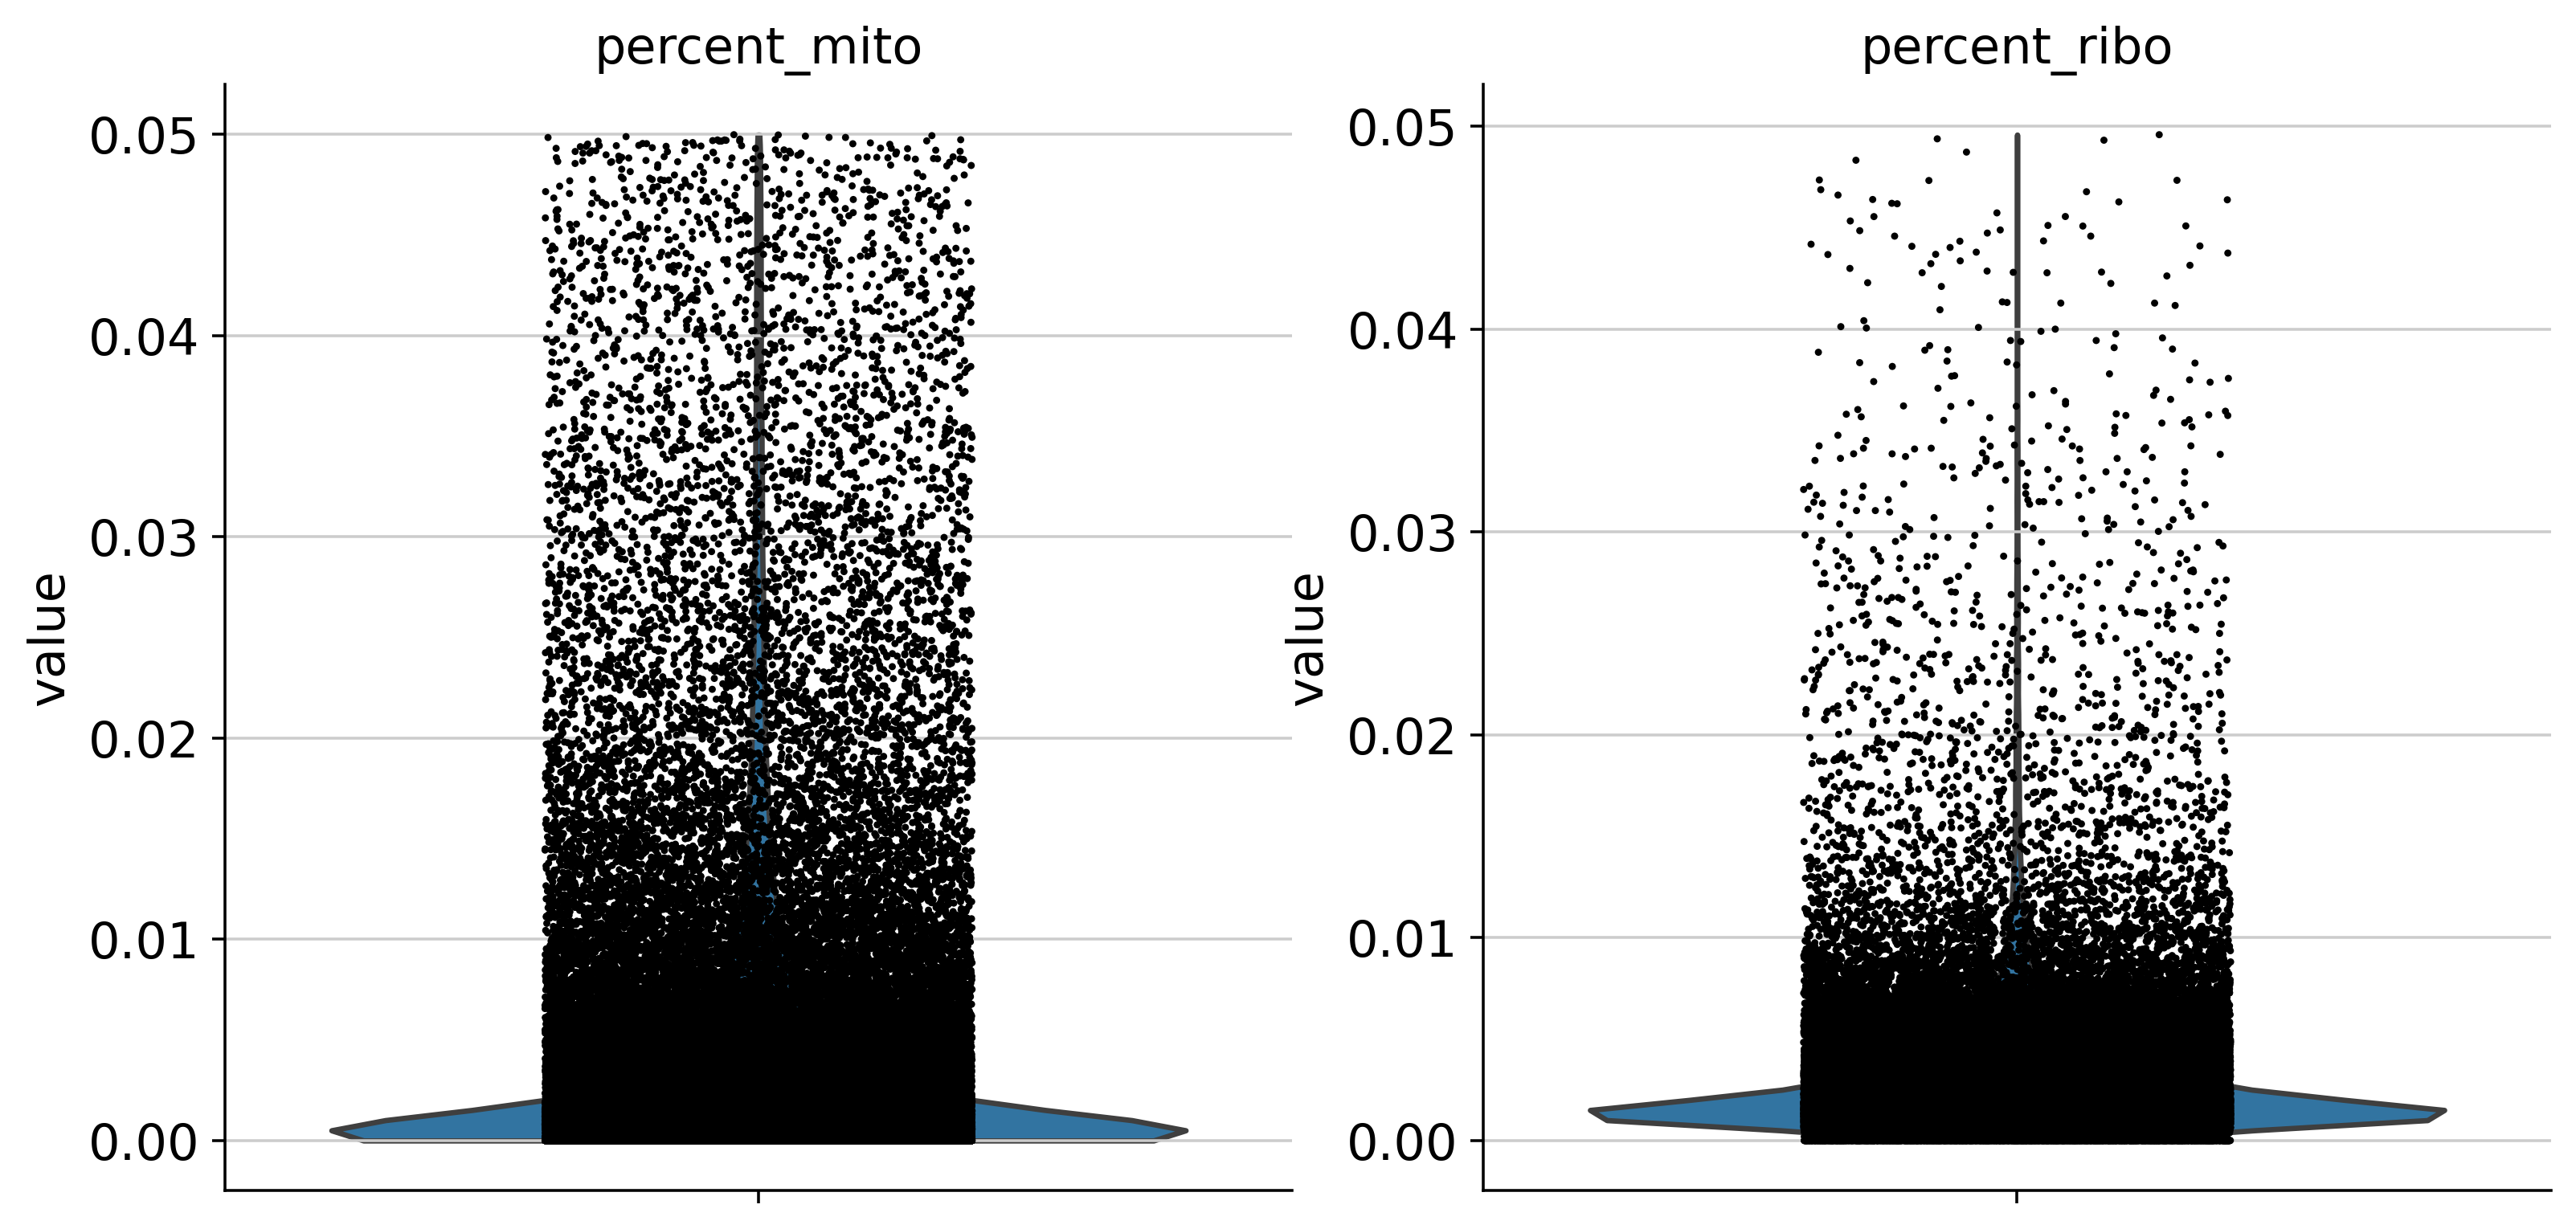

In [16]:
plt.rcParams['figure.figsize'] = [2, 2]
adata = adata[adata.obs['percent_mito'] < 0.05, :]
adata = adata[adata.obs['percent_ribo'] < 0.05, :]
sc.pl.violin(adata, ['percent_mito', 'percent_ribo'],jitter = 0.2, multi_panel = True, size=2)

In [17]:
adata.shape

(66504, 33608)

In [18]:
adata_backup = adata.copy()

In [19]:
for i in range(len(metadata.index)):
    ad = adata[adata.obs.sample_id == metadata.index[i],:].copy()
    run_scrublet(ad)
    if i==0:
        meta = ad.obs
    else:
        meta = pd.concat([meta, ad.obs])
    del ad

/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/heart/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_ca

In [20]:
meta_scrub = meta.loc[:,['scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval']].copy()

In [21]:
if meta.index.equals(adata.obs.index):
    adata.obs = pd.concat([adata.obs, meta_scrub], axis=1)
else:
    raise Exception('Different barcodes in meta and adata')

In [22]:
adata.write('/nfs/team205/heart/anndata_objects/multiome_RNA_adult.h5ad')

... storing 'scrublet_leiden' as categorical
